### Kennicott terminus area basmap background

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.windows import from_bounds
from shapely.geometry import Point
import pyproj

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import cmocean


In [2]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['legend.fontsize'] = 20


Import data

In [3]:
dempath_2012 = '/path/to/2012_dem.tif'
bedpath = '/path/to/bed_data.tif'


Prepare data

In [4]:
left, bottom, right, top = 558064, 1315038, 598912, 1357084 # manually defined bounds
ifsar_src = rio.open(dempath_2012,'r')
profile = ifsar_src.profile
dx, dy = round(ifsar_src.transform[0]), round(ifsar_src.transform[4])
ifsar_dem_2012 = ifsar_src.read(1, window=from_bounds(left, bottom, right, top, ifsar_src.transform))
crs = ifsar_src.crs


In [5]:
# load RGI for kennicott
shp1957 = gpd.read_file('/path/to/1957_outline.gpkg') # this is Kennicott and Root
shp2018 = gpd.read_file('/path/to/2018_Ootline.gpkg')
shp1957.to_crs('EPSG:3338', inplace=True)
shp2018.to_crs('EPSG:3338', inplace=True)


In [6]:
# load bed data
bed_src = rio.open(bedpath)
bed = rio.open(bedpath).read(1)
bed[bed == -9999] = np.nan
bed[bed == 0] = np.nan


In [7]:
# Create a hillshade: Shade from the northwest, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=315, altdeg=45)
ifsar_hs = ls.hillshade(ifsar_dem_2012, vert_exag=1, dx=dx, dy=dy)


Bathymetry data

In [8]:
# bathymetry data
bathy = pd.read_csv('/path/to/bathymetry_data.csv')
lon_values_bathy = bathy['x'].tolist()
lat_values_bathy = bathy['y'].tolist()


In [9]:
# convert to epsg 3338
src_crs = pyproj.CRS('EPSG:32607')
target_crs = pyproj.CRS('EPSG:3338')
transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
x_vals_bathy, y_vals_bathy = transformer.transform(lon_values_bathy, lat_values_bathy)


Radar data

In [10]:
# import bed picks
bedpicks_path = '/path/to/radar_bedpicks.csv'
df = pd.read_csv(bedpicks_path)
df = df[df.bed_elev.notnull()] # filter null points

# Extract the 'lat' and 'lon' columns and store them in a list
lon_values = df['lon'].tolist()
lat_values = df['lat'].tolist()


In [11]:
# convert to epsg 3338
src_crs = pyproj.CRS('EPSG:4326')
target_crs = pyproj.CRS('EPSG:3338')
transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
x_vals, y_vals = transformer.transform(lon_values, lat_values)


### Plot

/var/folders/x7/qhpb7wmn6pdf6v3b70f_mm800000gn/T/ipykernel_82744/3037764325.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


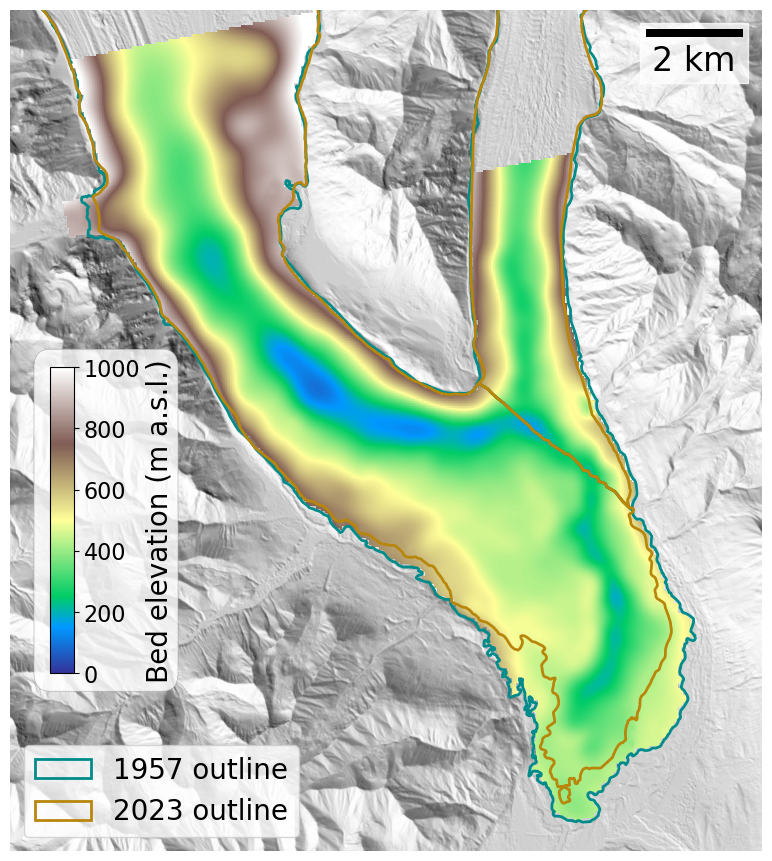

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 9))
ax.imshow(ifsar_hs, cmap='gray', extent=[left, right, bottom, top])

# bed data
cm = ax.imshow(bed, cmap='terrain', vmin=0, vmax=1000, 
               extent=[bed_src.bounds.left, bed_src.bounds.right, bed_src.bounds.bottom, bed_src.bounds.top])
divider = make_axes_locatable(ax)

# add the colorbar inside the plot
bg = patches.FancyBboxPatch((0.08, 0.23), 0.14, 0.34, boxstyle="round,pad=0.02", 
                            transform=fig.transFigure, color='w', ec='darkgray', lw=0.5, alpha=0.8, zorder=1) # center left
fig.patches.append(bg)
cax = fig.add_axes([0.08, 0.23, 0.03, 0.34], zorder=2)  # [left, bottom, width, height] in fraction of figure
fig.colorbar(cm, cax=cax, orientation='vertical', label='Bed elevation (m a.s.l.)')

# add glacier outline
shp1957.plot(ax=ax, fc='none', ec='darkcyan', lw=2, label='1957')
shp2018.plot(ax=ax, fc='none', ec='darkgoldenrod', lw=2, label='2023')

legend_handles = [Patch(fc='none', ec='darkcyan', lw=2, label='1957 outline'),
                  Patch(fc='none', ec='darkgoldenrod', lw=2, label='2023 outline')]
ax.legend(handles=legend_handles, loc='lower left')
    
# add scalebar
scalebar = ScaleBar(1,  # 1 data unit per pixel
                    location='upper right',  # location of the scalebar
                    length_fraction=0.2,  # relative length of the scalebar
                    box_color='white',  # box background color
                    box_alpha=0.75,  # transparency of the background box
                    color='black', border_pad=0.5, font_properties={'size':24})

ax.add_artist(scalebar)

# set axis bounds
ax.set_xlim(bed_src.bounds.left - 500, bed_src.bounds.right + 700)
ax.set_ylim(bed_src.bounds.bottom + 1000, bed_src.bounds.top - 1000)
ax.axis('off')

fig.tight_layout()
plt.show()


### Just plot the GPR data

In [13]:
# bed uncertainty
bedpath_std = '/path/to/bed_uncertainty.tif' # new radar data
# load bed data
bed_src_std = rio.open(bedpath_std)
bed_std = rio.open(bedpath_std).read(1)
bed_std[bed_std == -9999] = np.nan
bed_std[bed_std == 0] = np.nan


In [14]:
from raster_basics.RasterBasics import rasterMath, rasterLike, rOpen

# bed thickness
thickness_fp = '/path/to/bed_thickness.tif' # new radar data

# hugonnet dhdt data
hugonnet_dhdt_2000_2020 = '/path/to/hugonnet_dhdt_2000-2020.tif'

# ice thickness farinotti data
millan_thickness = '/code/tempthickness_millan_epsg3338.tif'
farinotti_thickness = '/code/tempthickness_farinotti_epsg3338.tif'
farinotti_thickness_r = '/code/tempthickness_farinotti_root_epsg3338.tif'
farinotti_thickness_k = '/code/tempthickness_farinotti_kenn_epsg3338.tif'

# compute difference
rasterMath(farinotti_thickness_k, farinotti_thickness_r, '+', outfile=farinotti_thickness) # merge farinotti files
rasterLike(rOpen(hugonnet_dhdt_2000_2020)*23, 'hug_23years_change.tif', hugonnet_dhdt_2000_2020)

rasterMath(thickness_fp, 'hug_23years_change.tif', '-', outfile='bed_thick_2000.tif') # adjust thickness by 23 years

rasterMath('bed_thick_2000.tif', millan_thickness, '-', outfile='temp_thick1.tif')
rasterMath('bed_thick_2000.tif', farinotti_thickness, '-', outfile='temp_thick2.tif')

# mask out bad values
t1 = rOpen('temp_thick1.tif')
t2 = rOpen('temp_thick2.tif')
t1[np.abs(t1) > 1000] = np.nan
t2[np.abs(t2) > 1000] = np.nan

os.remove('hug_23years_change.tif')
os.remove('bed_thick_2000.tif')
os.remove('temp_thick1.tif')
os.remove('temp_thick2.tif')


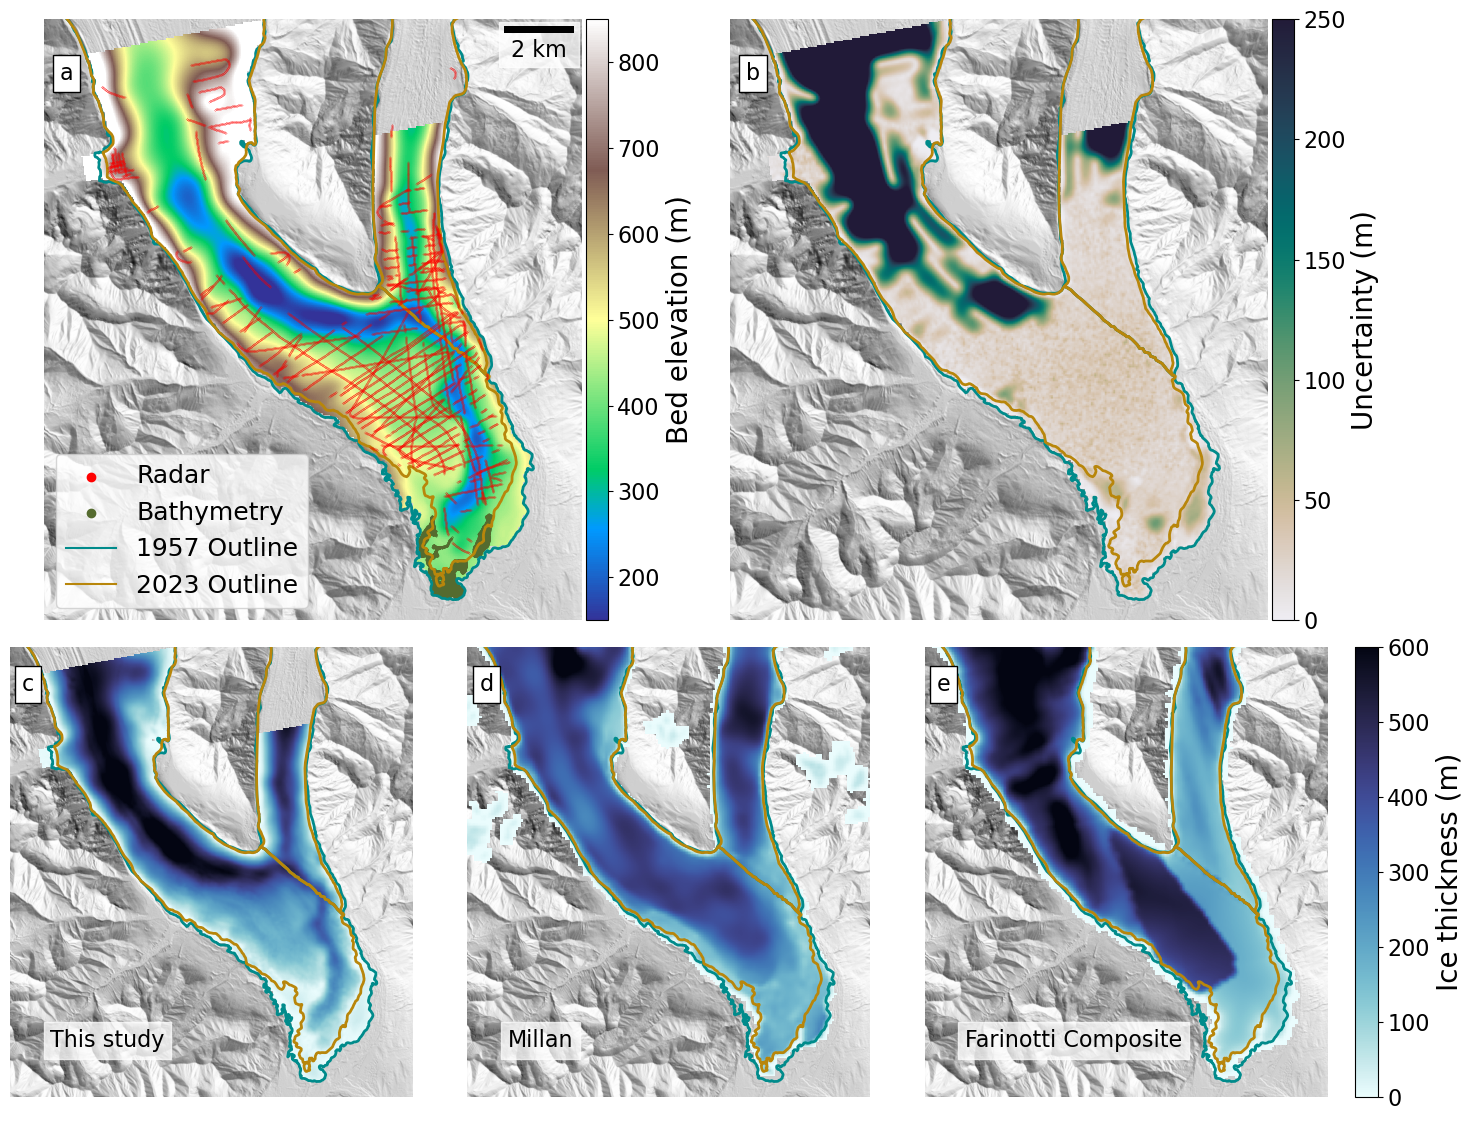

In [16]:
ax = plt.figure(constrained_layout=False, figsize=(18, 14)).subplot_mosaic(
    """
    AAABBB.
    CCDDEEF
    """,
    gridspec_kw={"height_ratios": [2.67, 2], "width_ratios": [1,1,1,1,1,1,0.1], "wspace": 0, "hspace": 0.05},
)

# plot orthophotos
ax1 = ax['A']
ax2 = ax['B']
ax3 = ax['C']
ax4 = ax['D']
ax5 = ax['E']
ax6 = ax['F']
axs = [ax1, ax2, ax3, ax4, ax5]

for ax in axs:
    ax.imshow(ifsar_hs, cmap='gray', extent=[left, right, bottom, top])

# 2D bed elevation
cm1 = ax1.imshow(bed, cmap='terrain', vmin=150, vmax=850,
                 extent=[bed_src.bounds.left, bed_src.bounds.right, bed_src.bounds.bottom, bed_src.bounds.top])
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='4%', pad=0.05)
fig.colorbar(cm1, cax=cax1, orientation='vertical', label='Bed elevation (m)')

# 2D bed elevation uncertainty
cm2 = ax2.imshow(bed_std*2, cmap=cmocean.cm.rain, vmin=0, vmax=250,
                 extent=[bed_src_std.bounds.left, bed_src_std.bounds.right, bed_src_std.bounds.bottom, bed_src_std.bounds.top])
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='4%', pad=0.05)
fig.colorbar(cm2, cax=cax2, orientation='vertical', label='Uncertainty (m)')

# plot bathymetry
ax1.scatter(x_vals_bathy, y_vals_bathy, c='darkolivegreen', marker='.', s=0.02, alpha=1) #, label='Bathymetry')

# radar points
ax1.scatter(x_vals, y_vals, c='r', marker='.', s=0.05, alpha=1, zorder=10) #, label='Radar')


# add ice thickness data
for ax, h_fp in list(zip([ax3, ax4, ax5], [thickness_fp, millan_thickness, farinotti_thickness])):
    arr = rOpen(h_fp)
    arr[arr<=0] = np.nan
    cm = ax.imshow(arr, cmap=cmocean.cm.ice_r, vmin=0, vmax=600,
                   extent=[rio.open(h_fp).bounds.left, rio.open(h_fp).bounds.right, rio.open(h_fp).bounds.bottom, rio.open(h_fp).bounds.top])

fig.colorbar(cm, cax=ax6, orientation='vertical', label='Ice thickness (m)')

# label plots
for ax, t in list(zip([ax3, ax4, ax5], ['This study', 'Millan', 'Farinotti Composite'])):
    ax.text(0.10, 0.10, t, transform=ax.transAxes, fontsize=16, 
            va='bottom', bbox=dict(boxstyle='Square', fc='w', ec='w', alpha=0.75))

# outlines
for ax in axs:
    shp1957.plot(ax=ax, fc='none', ec='darkcyan', lw=2, zorder=9) #, label='1957')
    shp2018.plot(ax=ax, fc='none', ec='darkgoldenrod', lw=2, zorder=9) #, label='2023')

# set axis bounds
for i, ax in enumerate(axs):
    ax.text(0.03, 0.89, chr(97+i).lower(), transform=ax.transAxes, fontsize=16, 
            va='bottom', bbox=dict(boxstyle='Square', fc='w', ec='k'), zorder=10)
    ax.set_xlim(bed_src.bounds.left - 500, bed_src.bounds.right + 700)
    ax.set_ylim(bed_src.bounds.bottom + 1000, bed_src.bounds.top - 1000)
    ax.axis('off')

# add scalebar
scalebar = ScaleBar(1,  # 1 data unit per pixel
                    location='upper right',  # location of the scalebar
                    length_fraction=0.2,  # relative length of the scalebar
                    box_color='white',  # box background color
                    box_alpha=0.75,  # transparency of the background box
                    color='black')  # scalebar color

ax1.add_artist(scalebar)

# make a legend
plt.rcParams['legend.fontsize'] = 18
ax1.scatter([], [], c='r', marker='o', label='Radar')
ax1.scatter([], [], c='darkolivegreen', marker='o', label='Bathymetry')
ax1.plot([], [], c='darkcyan', ls='-', label='1957 Outline')
ax1.plot([], [], c='darkgoldenrod', ls='-', label='2023 Outline')
ax1.legend()
plt.show()
